# Submission Code

In [2]:
# install the required packages first
require(jsonlite)
require(httr)
require(data.table)

get_token <- function(username, password, url_site){
    
    post_body = list(username=username,password=password)
    post_url_string = paste0(url_site,'/token/')
    result = POST(post_url_string, body = post_body)

    # error handling (wrong credentials)
    if(result$status_code==400){
        print('Check your credentials')
        return(0)
    }
    else if (result$status_code==201){
        output = content(result)
        token = output$key
    }

    return(token)
}



send_submission <- function(predictions, token, url_site, submit_now=F){
    
    format_check=check_format(predictions)
    if(!format_check){
        return(FALSE)
    }
    
    post_string="list("
    for(i in 1:length(predictions)){
        if(i<length(predictions)){
            post_string=sprintf("%s%s,",post_string,predictions[i])
        } else {
            post_string=sprintf("%s%s)",post_string,predictions[i])
        }
    }
    
    submission = eval(parse(text=post_string))
    json_body = jsonlite::toJSON(submission, auto_unbox = TRUE)
    submission=list(submission=json_body)
    print(submission)

    if(!submit_now){
        print("You did not submit.")
        return(FALSE)      
    }
    

    header = add_headers(c(Authorization=paste('Token',token,sep=' ')))
    post_url_string = paste0(url_site,'/submission/')
    result = POST(post_url_string, header, body=submission)
    
    if (result$status_code==201){
        print("Successfully submitted. Below you can see the details of your submission")
    } else {
        print("Could not submit. Please check the error message below, contact the assistant if needed.")
    }
    
    print(content(result))
    
}

check_format <- function(predictions){
    
    if(all(is.numeric(predictions)) & all(predictions<=1)){
        print("Format OK")
        return(TRUE)
    } else {
        print("Wrong format")
        return(FALSE)
    }
    
}

# this part is main code
subm_url = 'http://46.101.121.83'

u_name = "Miners"
p_word = "NsY7hhlU9zjl8DH3"
submit_now = TRUE

username = u_name
password = p_word

token = get_token(username=u_name, password=p_word, url=subm_url)
# this part is where you need to provide your prediction method/function or set of R codes


### Performance Function

In [3]:
perf_dt=function(type,actual,forecast){
    name=type
    n=length(actual)
    error=actual-forecast
    mean=mean(actual)
    sd=sd(actual)
    FBias=sum(error)/sum(actual)
    MPE=sum(error/actual)/n
    MAPE=sum(abs(error/actual))/n
    RMSE=sqrt(sum(error^2))/n
    MAD=sum(abs(error))/n
    WMAPE=MAD/mean
    l=data.frame(name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE)
    return(l)
}

# Model

In [5]:
library(xlsx)
library(caret)
library(e1071)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(Information)
library(FactoMineR)
library(caTools)

In [6]:
TrainData<-read.csv("IE582_Fall20_ProjectTrain.csv")

TrainData<-TrainData[,-c(37,50,52,57)]

TestData<-read.csv("IE582_Fall20_ProjectTest.csv")

TestData<-TestData[,-c(37,50,52,57)]

In [7]:
TrainData=as.data.table(TrainData)
TestData=as.data.table(TestData)
TrainData$index=1:nrow(TrainData)
TestData$index=1:nrow(TestData)

In [8]:
balanced_TrainData=TrainData[x60==0 & x59==0 & x58==0& x46==0& x26==0& x24==0& x16==0& x49==0&
                x43==0 & x39==0 & x29==0 & x19==0 & x18==0,]
balanced_TestData=TestData[x60==0 & x59==0 & x58==0& x46==0& x26==0& x24==0& x16==0& x49==0&
                x43==0 & x39==0 & x29==0 & x19==0 & x18==0,]

In [9]:
balanced_TrainData<-balanced_TrainData[,-c("x60", "x59", "x58", "x46", "x26", "x24", "x16", "x49",
                                           "x43", "x39", "x29", "x19", "x18" ,"x54")]


balanced_TestData<-balanced_TestData[,-c("x60", "x59", "x58", "x46", "x26", "x24", "x16", "x49",
                                           "x43", "x39", "x29", "x19", "x18","x54")]

In [25]:
otherbalanced_TrainData=TrainData[!(x60==0 & x59==0 & x58==0& x46==0& x26==0& x24==0& x16==0& x49==0&
                x43==0 & x39==0 & x29==0 & x19==0 & x18==0& x54==0)]

otherbalanced_TestData=TestData[!(x60==0 & x59==0 & x58==0& x46==0& x26==0& x24==0& x16==0& x49==0&
                x43==0 & x39==0 & x29==0 & x19==0 & x18==0& x54==0)]

In [26]:
otherbalanced_TrainData$y=as.factor(otherbalanced_TrainData$y)

In [27]:
balanced_TrainData$y=as.numeric(balanced_TrainData$y)

In [28]:
table(balanced_TrainData$y)


  1   2 
676 425 

In [29]:
table(otherbalanced_TrainData$y)


   a    b 
1095  113 

# Prediction & Control with Train Dataset

In [30]:
fitControl=trainControl(method = "repeatedcv",
                           number = 20)

In [31]:
gbmGrid=expand.grid(interaction.depth = c(1, 3, 5), 
                        n.trees = (1:5)*25, 
                        shrinkage = c(0.1, 0.3, 0.5),
                        n.minobsinnode = 20)

Stochastic Gradient Boosting 

1208 samples
  57 predictor
   2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (20 fold, repeated 1 times) 
Summary of sample sizes: 1147, 1147, 1148, 1148, 1148, 1148, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa    
  0.1        1                   25      0.9114481  0.1434316
  0.1        1                   50      0.9147131  0.2478694
  0.1        1                   75      0.9163798  0.3142217
  0.1        1                  100      0.9172131  0.3355609
  0.1        1                  125      0.9172268  0.3313698
  0.1        3                   25      0.9180464  0.2912501
  0.1        3                   50      0.9130738  0.3138469
  0.1        3                   75      0.9138934  0.3418716
  0.1        3                  100      0.9147268  0.3456331
  0.1        3                  125      0.9105464  0.3233278
  0.1        5                   25      0.9163

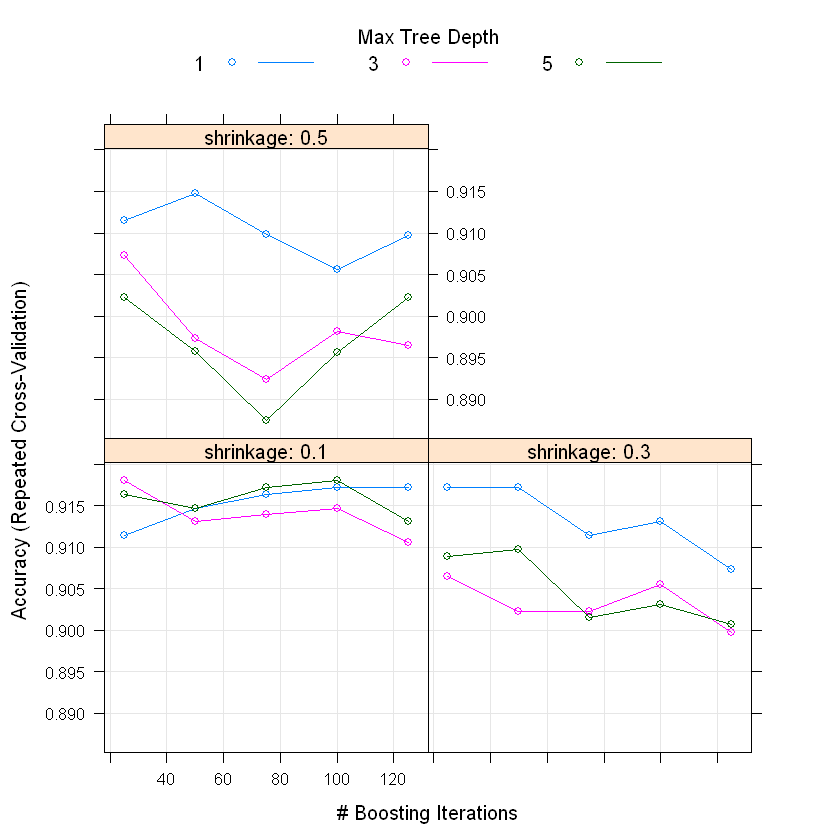

In [32]:
gbm_fit=train(as.factor(y) ~ .-index, data = otherbalanced_TrainData, 
                 method = "gbm", 
                 trControl = fitControl,  
                 tuneGrid = gbmGrid,
                 verbose=F)

gbm_fit
plot(gbm_fit)

In [33]:
predictions_train=predict(gbm_fit,otherbalanced_TrainData)

In [34]:
perf_dt("Performance Measure", as.numeric(predictions_train), as.numeric(otherbalanced_TrainData$y))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Performance Measure,1208,1.062086,0.2414118,-0.02961808,0.03518212,0.005491101,0.03642384,0.03429462


In [35]:
confusionMatrix(data = as.factor(predictions_train), reference = as.factor(otherbalanced_TrainData$y), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction    a    b
         a 1092   41
         b    3   72
                                          
               Accuracy : 0.9636          
                 95% CI : (0.9514, 0.9734)
    No Information Rate : 0.9065          
    P-Value [Acc > NIR] : 1.298e-14       
                                          
                  Kappa : 0.7471          
                                          
 Mcnemar's Test P-Value : 2.434e-08       
                                          
              Precision : 0.9638          
                 Recall : 0.9973          
                     F1 : 0.9803          
             Prevalence : 0.9065          
         Detection Rate : 0.9040          
   Detection Prevalence : 0.9379          
      Balanced Accuracy : 0.8172          
                                          
       'Positive' Class : a               
                                          

In [36]:
otherbalanced_TrainData$y_pred_sth=as.numeric(predictions_train)-1

# Other Model

In [ ]:
gbm_fit1=train(y ~ .-index, data = TrainData, 
                 method = "gbm", 
                 trControl = fitControl,  
                 tuneGrid = gbmGrid,
                 verbose=F)

gbm_fit1
plot(gbm_fit1)

In [ ]:
final_prediction=predict(gbm_fit1,TrainData)

In [ ]:
table(TrainData$y,final_prediction)

In [ ]:
confusionMatrix(data = as.factor(final_prediction), reference = as.factor(TrainData$y), mode = "prec_recall")

In [ ]:
TrainData$pred=as.numeric(final_prediction)-1

In [24]:
j=1
for(i in 1:nrow(TrainData)){
    if(TrainData[i]$index==otherbalanced_TrainData[j]$index){
        TrainData[i]$pred=otherbalanced_TrainData[j]$y_pred_sth
        j=j+1
    }  
}

In [25]:
confusionMatrix(data = as.factor(TrainData$pred), reference = as.factor(as.numeric(TrainData$y)-1), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1497  220
         1   68  289
                                          
               Accuracy : 0.8611          
                 95% CI : (0.8455, 0.8757)
    No Information Rate : 0.7546          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5831          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.8719          
                 Recall : 0.9565          
                     F1 : 0.9122          
             Prevalence : 0.7546          
         Detection Rate : 0.7218          
   Detection Prevalence : 0.8279          
      Balanced Accuracy : 0.7622          
                                          
       'Positive' Class : 0               
                                          

# Random Forest

In [26]:
library(ranger)

Warning message:
"package 'ranger' was built under R version 3.6.3"

In [27]:
rf_grid=expand.grid(mtry=c(4,8,10,15,20,30),
                   splitrule = c("extratrees"),
                   min.node.size= c(20))
rf_grid

mtry,splitrule,min.node.size
4,extratrees,20
8,extratrees,20
10,extratrees,20
15,extratrees,20
20,extratrees,20
30,extratrees,20


In [28]:
rf_fit=train(as.factor(y) ~ .-index, data = otherbalanced_TrainData, 
                 method = "ranger", 
                 trControl = fitControl, num.trees=500,
                 tuneGrid = rf_grid)
rf_fit

Random Forest 

1208 samples
  58 predictor
   2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (20 fold, repeated 1 times) 
Summary of sample sizes: 1147, 1148, 1147, 1147, 1147, 1147, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   4    0.9123046  0.1731490
   8    0.9247103  0.3658655
  10    0.9263633  0.3785581
  15    0.9272103  0.4223205
  20    0.9280300  0.4320330
  30    0.9288633  0.4487731

Tuning parameter 'splitrule' was held constant at a value of extratrees

Tuning parameter 'min.node.size' was held constant at a value of 20
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 30, splitrule = extratrees
 and min.node.size = 20.

In [29]:
PredictRandomForest=predict(rf_fit,newdata=otherbalanced_TrainData)

In [30]:
perf_dt("Random Forest",as.numeric(otherbalanced_TrainData$y),as.numeric(PredictRandomForest))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Random Forest,1208,1.093543,0.2913125,0.03785011,0.03807947,0.00731106,0.06456954,0.05904618


In [31]:
confusionMatrix(data = as.factor(PredictRandomForest), reference = as.factor(otherbalanced_TrainData$y), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction    a    b
         a 1081   64
         b   14   49
                                          
               Accuracy : 0.9354          
                 95% CI : (0.9201, 0.9486)
    No Information Rate : 0.9065          
    P-Value [Acc > NIR] : 0.0001752       
                                          
                  Kappa : 0.525           
                                          
 Mcnemar's Test P-Value : 2.887e-08       
                                          
              Precision : 0.9441          
                 Recall : 0.9872          
                     F1 : 0.9652          
             Prevalence : 0.9065          
         Detection Rate : 0.8949          
   Detection Prevalence : 0.9478          
      Balanced Accuracy : 0.7104          
                                          
       'Positive' Class : a               
                                          

# Final Random

In [32]:
rf_fit1=train(as.factor(y) ~ .-index, data = TrainData, 
                 method = "ranger", 
                 trControl = fitControl, num.trees=500,
                 tuneGrid = rf_grid)
rf_fit1

Random Forest 

2074 samples
  58 predictor
   2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (20 fold, repeated 1 times) 
Summary of sample sizes: 1970, 1970, 1971, 1969, 1970, 1970, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   4    0.8572838  0.5656848
   8    0.8601870  0.5805725
  10    0.8597247  0.5812124
  15    0.8582592  0.5773529
  20    0.8592301  0.5795650
  30    0.8568168  0.5740990

Tuning parameter 'splitrule' was held constant at a value of extratrees

Tuning parameter 'min.node.size' was held constant at a value of 20
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 8, splitrule = extratrees
 and min.node.size = 20.

In [33]:
PredictRandomForest1=predict(rf_fit1,newdata=TrainData)

In [34]:
perf_dt("Random Forest",as.numeric(TrainData$y),as.numeric(PredictRandomForest1))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Random Forest,2074,1.245419,0.4304394,0.04684475,0.07545805,0.007608358,0.1200579,0.09639954


In [35]:
confusionMatrix(data = as.factor(PredictRandomForest1), reference = as.factor(TrainData$y), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction    a    b
         a 1501  185
         b   64  324
                                          
               Accuracy : 0.8799          
                 95% CI : (0.8652, 0.8936)
    No Information Rate : 0.7546          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6476          
                                          
 Mcnemar's Test P-Value : 2.856e-14       
                                          
              Precision : 0.8903          
                 Recall : 0.9591          
                     F1 : 0.9234          
             Prevalence : 0.7546          
         Detection Rate : 0.7237          
   Detection Prevalence : 0.8129          
      Balanced Accuracy : 0.7978          
                                          
       'Positive' Class : a               
                                          

In [36]:
TrainData$last_y=PredictRandomForest1

In [37]:
otherbalanced_TrainData$y_pred_rnd=PredictRandomForest

In [38]:
j=1
for(i in 1:nrow(TrainData)){
    if(TrainData[i]$index==otherbalanced_TrainData[j]$index){
        TrainData[i]$last_y=otherbalanced_TrainData[j]$y_pred_rnd
        j=j+1
    }  
}

In [39]:
confusionMatrix(data = as.factor(TrainData$last_y), reference = as.factor(TrainData$y), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction    a    b
         a 1497  182
         b   68  327
                                          
               Accuracy : 0.8795          
                 95% CI : (0.8647, 0.8932)
    No Information Rate : 0.7546          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6479          
                                          
 Mcnemar's Test P-Value : 8.886e-13       
                                          
              Precision : 0.8916          
                 Recall : 0.9565          
                     F1 : 0.9229          
             Prevalence : 0.7546          
         Detection Rate : 0.7218          
   Detection Prevalence : 0.8095          
      Balanced Accuracy : 0.7995          
                                          
       'Positive' Class : a               
                                          

# Prediction

In [60]:
predictions_train=predict(gbm_fit,otherbalanced_TestData)

In [61]:
otherbalanced_TestData$y_pred_sth=as.numeric(predictions_train)-1

In [62]:
final_prediction=predict(gbm_fit1,TestData)

In [63]:
TestData$pred=as.numeric(final_prediction)-1

In [64]:
j=1
for(i in 1:nrow(TestData)){
    if(TestData[i]$index==otherbalanced_TestData[j]$index){
        TestData[i]$pred=otherbalanced_TestData[j]$y_pred_sth
        j=j+1
    }  
}

In [78]:
table()


   0    1 
1728  345 

In [65]:
PredictRandomForest=predict(rf_fit,newdata=otherbalanced_TestData)

In [66]:
otherbalanced_TestData$y_pred_rnd=PredictRandomForest

In [67]:
PredictRandomForest1=predict(rf_fit1,newdata=TestData)

In [68]:
TestData$last_y=PredictRandomForest1

In [69]:
j=1
for(i in 1:nrow(TestData)){
    if(TestData[i]$index==otherbalanced_TestData[j]$index){
        TestData[i]$last_y=otherbalanced_TestData[j]$y_pred_rnd
        j=j+1
    }  
}

In [71]:
TestData$last_y=as.numeric(TestData$last_y)-1

In [79]:
table(TestData$last_y)


   0    1 
1707  366 

# Submission

In [80]:
send_submission(as.numeric(final_prediction)-1, token, url=subm_url, submit_now= submit_now)

[1] "Format OK"
$submission
[0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0